# 인도 유제품 폐기율 분석 및 프로틴 시장 진출 전략 제안

## 🔹 프로젝트 개요
### 한 줄 요약: 인도 낙농업 데이터의 높은 폐기율(약 40%) 문제의 핵심 원인을 데이터 분석으로 규명하고, '프로틴 파우더'라는 사업적 해결책을 제시한 프로젝트입니다.

### 주요 분석 내용
1. **예상 폐기율 KPI 수립**: 판매 데이터와 재고 데이터를 조합하여 핵심 지표 개발
2. **원인 분석**: 통계적 가설 검정을 통한 폐기율 영향 요인 규명
3. **예측 모델링**: Random Forest 분류 모델(AUC 0.77)로 폐기 발생 예측
4. **전략 제시**: K-Means 군집 분석으로 농장 그룹화 및 맞춤 전략 제안

### 사용 기술
**언어**: Python  
**라이브러리**: Pandas, NumPy, Seaborn, Matplotlib, Scikit-learn, Statsmodels, XGBoost  
**툴**: Jupyter Notebook, Tableau


In [ ]:
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
# 데이터 처리 및 분석을 위한 라이브러리
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings('ignore')

# 통계 분석을 위한 라이브러리
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from scipy.stats import f_oneway, ttest_ind

# 머신러닝을 위한 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    r2_score, mean_absolute_error, mean_squared_error, roc_curve, auc, silhouette_score
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

from adjustText import adjust_text
from collections import Counter

# 시각화 설정
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'

## 2. 데이터 로드 및 기본 정보 확인


In [ ]:
path = "/content/drive/MyDrive/멋쟁이사자처럼 데이터분석/파이널프로젝트/우유/archive (3)/dairy_dataset.csv"
df = pd.read_csv(path)

# 컬럼명 정리
df.columns = df.columns.str.replace('(liters/kg)', '', regex=False)
df.columns = df.columns.str.replace('(days)', '', regex=False)
df.columns = df.columns.str.replace('(acres)', '', regex=False)
df.columns = df.columns.str.replace('(sold)', 'Sold', regex=False)
df.columns = df.columns.str.replace('(INR)', '', regex=False)
df.columns = df.columns.str.replace('.', '', regex=False)
df.columns = df.columns.str.rstrip()
df = df.rename(columns=lambda x: x.replace(' ', '_'))

print("데이터셋 기본 정보:")
print(f"데이터 크기: {df.shape}")
print(f"컬럼 수: {df.shape[1]}")
print(f"행 수: {df.shape[0]}")
print("\n컬럼명:")
print(df.columns.tolist())

데이터셋 기본 정보:
데이터 크기: (4325, 23)
컬럼 수: 23
행 수: 4325

컬럼명:
['Location', 'Total_Land_Area', 'Number_of_Cows', 'Farm_Size', 'Date', 'Product_ID', 'Product_Name', 'Brand', 'Quantity', 'Price_per_Unit', 'Total_Value', 'Shelf_Life', 'Storage_Condition', 'Production_Date', 'Expiration_Date', 'Quantity_Sold', 'Price_per_Unit_Sold', 'Approx_Total_Revenue', 'Customer_Location', 'Sales_Channel', 'Quantity_in_Stock', 'Minimum_Stock_Threshold', 'Reorder_Quantity']


In [ ]:
# 데이터 타입 및 기본 통계
print("데이터 타입:")
print(df.dtypes)
print("\n기본 통계:")
print(df.describe())
print("\n결측값:")
print(df.isnull().sum())

데이터 타입:
Location                    object
Total_Land_Area            float64
Number_of_Cows               int64
Farm_Size                   object
Date                        object
Product_ID                   int64
Product_Name                object
Brand                       object
Quantity                   float64
Price_per_Unit             float64
Total_Value                float64
Shelf_Life                   int64
Storage_Condition           object
Production_Date             object
Expiration_Date             object
Quantity_Sold                int64
Price_per_Unit_Sold        float64
Approx_Total_Revenue       float64
Customer_Location           object
Sales_Channel               object
Quantity_in_Stock            int64
Minimum_Stock_Threshold    float64
Reorder_Quantity           float64
dtype: object

기본 통계:
       Total_Land_Area  Number_of_Cows   Product_ID     Quantity  \
count      4325.000000     4325.000000  4325.000000  4325.000000   
mean        503.483073       

## 3. 데이터 전처리 및 특성 엔지니어링


In [ ]:
# 날짜 컬럼 변환
date_columns = ['Date', 'Production_Date', 'Expiration_Date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col])

df["Prod_Year"] = df["Production_Date"].dt.year
df["Prod_Month"] = df["Production_Date"].dt.month
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df['Year_Month_str'] = df['Date'].dt.strftime('%Y-%m')

storage_map = {
    'Frozen': 'FR',
    'Refrigerated': 'RF',
    'Ambient': 'AM',
    'Polythene Packet': 'PP',
    'Tetra Pack': 'TP'
}

df['Product_Profile'] = df['Storage_Condition'].map(storage_map) + '_' + df['Product_Name']

# ==================================================================
# 📊 인플레이션 조정을 통한 실질가격 계산
# ==================================================================
# 1. 연도별 소비자 물가 지수(CPI) 설정
#    - 2019년을 기준년도(100)로 설정하여 인플레이션 영향을 제거
#    - 데이터 출처: World Bank, Macrotrends의 인도 연간 인플레이션율
#    - 2019: 3.73%, 2020: 6.62%, 2021: 5.13%, 2022: 6.70%
cpi_data = {
    2019: 100.0,    # 기준년도 CPI = 100
    2020: 106.62,   # 100 * (1 + 0.0662) = 인플레이션 반영
    2021: 112.10,   # 106.62 * (1 + 0.0513) = 누적 인플레이션 반영
    2022: 119.61    # 112.10 * (1 + 0.0670) = 누적 인플레이션 반영
}

# 2. 기준년도 CPI 설정 (2019년 = 100)
base_cpi = cpi_data[2019]

# 3. 각 년도별 CPI를 데이터프레임에 매핑
df['cpi'] = df['Year'].map(cpi_data)

# 4. 실질가격 계산 (인플레이션 제거)
#    공식: 실질가격 = 명목가격 ÷ (해당년도 CPI ÷ 기준년도 CPI)
#    목적: 시간에 따른 화폐가치 변화를 제거하여 순수한 가격 변화만 분석
df['Real_Price_per_Unit_Sold'] = df['Price_per_Unit_Sold'] / (df['cpi'] / base_cpi)

# 5. 임시 컬럼 정리
df.drop('cpi', axis=1, inplace=True)

# 📈 가격 정규화 및 할인율 계산
# ==================================================================
# 1. 제품별, 채널별 가격 정규화 (0-1 스케일)
#    목적: 제품군별로 다른 가격대를 동일한 스케일로 비교 가능하게 함
group_cols = ['Product_Name', 'Sales_Channel']
grouped = df.groupby(group_cols)['Real_Price_per_Unit_Sold']
min_prices = grouped.transform('min')  # 각 그룹의 최소가격
max_prices = grouped.transform('max')  # 각 그룹의 최대가격

# 정규화 공식: (현재가격 - 최소가격) ÷ (최대가격 - 최소가격)
df['Price_Score'] = (df['Real_Price_per_Unit_Sold'] - min_prices) / (max_prices - min_prices)
df['Price_Score'].fillna(0.5, inplace=True)  # NaN값은 중간값(0.5)으로 대체

# 2. 할인율 계산
#    공식: (정가 - 판매가) ÷ 정가 × 100
#    목적: 가격 정책의 효과성을 측정
df['Discount_Rate'] = (df['Price_per_Unit'] - df['Price_per_Unit_Sold']) / df['Price_per_Unit']
# ==================================================================

# 🎯 핵심 KPI 생성: 폐기율 예측을 위한 시간 기반 변수들
# ==================================================================
# 1. 시간 기반 변수 계산
df['Sales_Period_Days'] = (df['Date'] - df['Production_Date']).dt.days  # 생산일로부터 경과일수
df["Avg_Daily_Sales"] = df["Quantity_Sold"] / (df["Date"] - df["Production_Date"]).dt.days  # 일평균 판매량
df['Remaining_Shelf_Life'] = (df['Expiration_Date'] - df['Date']).dt.days  # 유통기한까지 남은 일수

# 2. 판매 속도 정규화 (Z-Score)
#    목적: 제품군별로 다른 판매 속도를 표준화하여 비교 가능하게 함
mean_sales = df.groupby('Product_Profile')['Avg_Daily_Sales'].transform('mean')  # 제품별 평균 판매량
std_sales = df.groupby('Product_Profile')['Avg_Daily_Sales'].transform('std')    # 제품별 표준편차
df['Sales_Velocity_ZScore'] = (df['Avg_Daily_Sales'] - mean_sales) / std_sales
df['Sales_Velocity_ZScore'].fillna(0, inplace=True)  # 표준편차가 0인 경우(모든 값이 동일) 0으로 처리

# 3. 예상 폐기량 계산 (핵심 KPI)
#    로직: 유통기한이 지났으면 → 재고량 전체가 폐기
#          유통기한이 남았으면 → (재고량 - 예상판매량) 중 양수만 폐기
df['Expected_Waste_Qty'] = np.where(
    df['Remaining_Shelf_Life'] <= 0,  # 유통기한 만료
    df['Quantity_in_Stock'],          # 전체 재고 폐기
    (df['Quantity_in_Stock'] - (df['Avg_Daily_Sales'] * df['Remaining_Shelf_Life'])).clip(lower=0)  # 남은 재고 폐기
)

# 4. 폐기율 및 리스크 지표 계산
df['Expected_Waste_Qty'] = df['Expected_Waste_Qty'].fillna(df['Quantity_in_Stock'])  # NaN값 처리
df['Waste_Rate'] = df['Expected_Waste_Qty'] / df['Quantity']  # 폐기율 = 예상폐기량 ÷ 총생산량
df['Days_to_Stockout'] = df['Quantity_in_Stock'] / df['Avg_Daily_Sales']  # 재고 소진 예상일수
df['Risk_Flag'] = df['Days_to_Stockout'] > df['Remaining_Shelf_Life']  # 리스크 플래그 (재고소진 > 유통기한)
df['Waste_Or_Not'] = np.where(df['Waste_Rate'] > 0, '폐기 발생', '폐기 없음')  # 이진 분류용 타겟 변수

# ==================================================================
df['Prod_per_Cow'] = (df['Quantity'] / df['Number_of_Cows']).fillna(0)
df['Revenue_per_Cow'] = df["Approx_Total_Revenue"] / df["Number_of_Cows"]
df['Prod_per_Acre'] = df['Quantity'] / df['Total_Land_Area']

# 'Product_Name'별로 Prod_per_Cow의 중앙값을 계산하여 각 행에 매핑
df['Product_Median_Prod'] = df.groupby('Product_Profile')['Prod_per_Cow'].transform('median')
df['Efficiency_Group_Product'] = df.apply(lambda row: '고효율 농장' if row['Prod_per_Cow'] > row['Product_Median_Prod'] else '저효율 농장', axis=1)
df.drop('Product_Median_Prod', axis=1, inplace=True)

df['Quantity_Median'] = df.groupby('Product_Profile')['Quantity'].transform('median')
df['Quantity_Group'] = df.apply(lambda row: '대량생산 농장' if row['Quantity'] > row['Quantity_Median'] else '소량생산 농장', axis=1)

## 4. 탐색적 데이터 분석 (EDA)


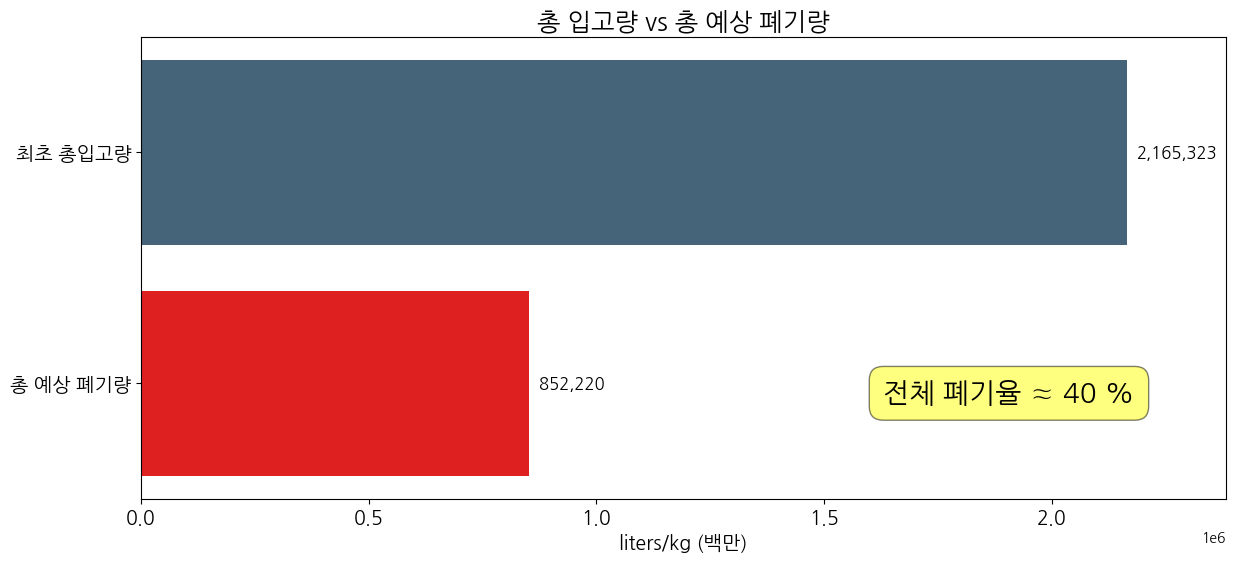

In [ ]:
# 1. 시각화할 데이터 계산
total_quantity = df['Quantity'].sum()
total_waste = df['Expected_Waste_Qty'].sum()

# 데이터 레이블과 값 설정
labels = ['최초 총입고량', '총 예상 폐기량']
values = [total_quantity, total_waste]

cl = ['#3C6682', 'red']
# 2. 시각화
plt.figure(figsize=(14, 6))
# 가로 막대그래프 생성: plt.barh()
ax = sns.barplot(x=values, y=labels, palette=cl)

# 3. 그래프 꾸미기
plt.title('총 입고량 vs 총 예상 폐기량', fontsize=18)
plt.xlabel('liters/kg (백만)', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim(0, total_quantity * 1.1) # x축 여유 공간 확보


# 막대 위에 실제 숫자 값 표시
for i, v in enumerate(values):
    ax.text(v + (total_quantity * 0.01), i, f'{v:,.0f}', color='black', va='center', fontsize=12)

plt.text(0.8, 0.2,'전체 폐기율 ≈ 40 %', transform=ax.transAxes, ha='center', va='bottom', fontsize=20, bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
plt.show()

--- 제품별 평균 폐기율 분석 ---
  Product_Name Waste_Rate
3         Curd      0.49%
1   Buttermilk      0.46%
8       Paneer      0.46%
7         Milk      0.44%
6        Lassi      0.43%
5    Ice Cream      0.40%
9       Yogurt      0.39%
0       Butter      0.37%
2       Cheese      0.26%
4         Ghee      0.16%
-----------------------------------


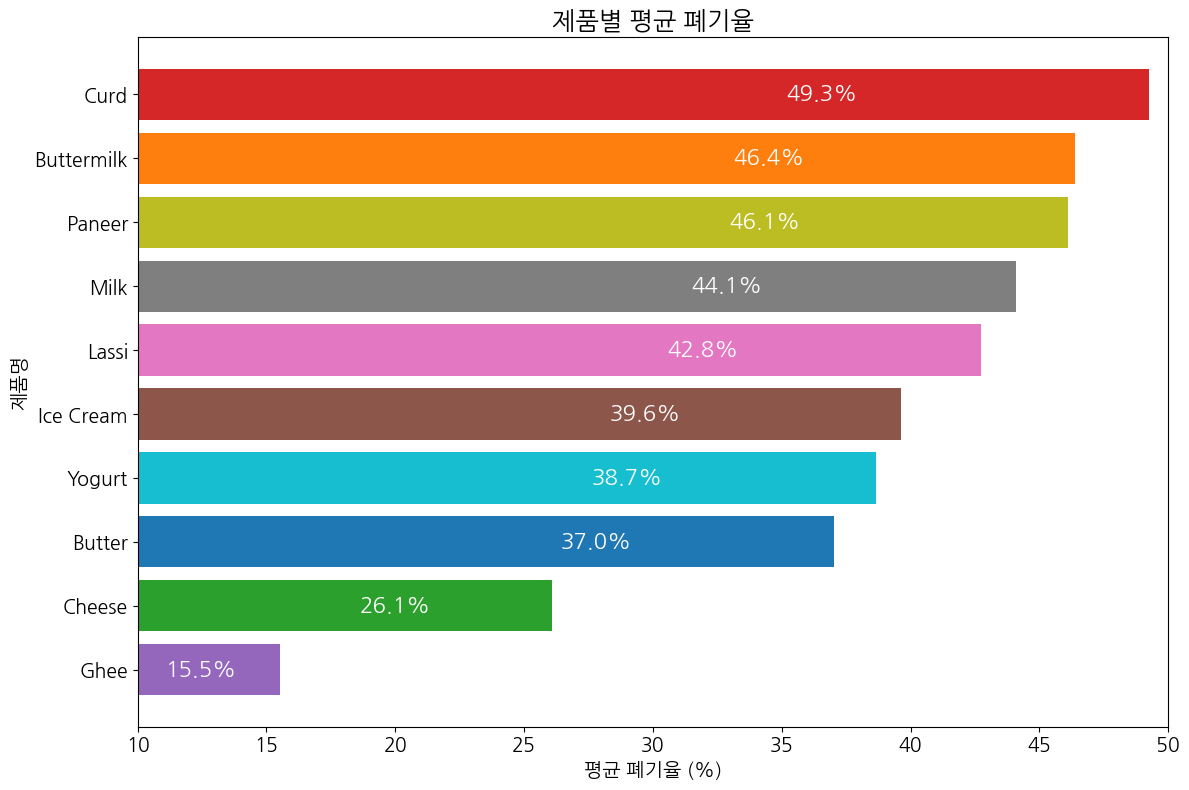

In [ ]:
product_counts = df['Product_Name'].value_counts()

product_waste_analysis = df.groupby('Product_Name')['Waste_Rate'].mean().reset_index()

# 2. 폐기율이 높은 순서대로 정렬합니다.
product_waste_sorted = product_waste_analysis.sort_values(by='Waste_Rate', ascending=False)

print("--- 제품별 평균 폐기율 분석 ---")
# 폐기율을 퍼센트(%) 형태로 보기 좋게 바꿉니다.
product_waste_sorted['Waste_Rate'] = product_waste_sorted['Waste_Rate'].apply(lambda x: f"{x:.2f}%")
print(product_waste_sorted)
print("-" * 35)


# 3. 시각화: 폐기율 상위 10개 제품
# 시각화를 위해 정렬된 데이터에서 숫자 부분만 다시 가져옵니다.
top_products_to_plot = product_waste_analysis.sort_values(by='Waste_Rate', ascending=False)
my_colors = ['#D62728', '#FF7F0E', '#BCBD22', '#7F7F7F', '#E377C2', '#8C564B', '#17BECF', '#1F77B4', '#2CA02C', '#9467BD']
plt.figure(figsize=(12, 8))
bars = plt.barh(top_products_to_plot['Product_Name'], top_products_to_plot['Waste_Rate']*100, color=my_colors)

plt.title(f'제품별 평균 폐기율', fontsize=18)
plt.xlabel('평균 폐기율 (%)', fontsize=14)
plt.ylabel('제품명', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(10,50)
plt.gca().invert_yaxis() # 높은 순서대로 위에서부터 표시

# 막대그래프에 퍼센트(%) 값 표시
for bar in bars:
    width = bar.get_width()
    plt.text(bar.get_x() + bar.get_width()/1.4, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', va='center', fontsize=16, color='white', fontweight='extra bold')

plt.tight_layout()
plt.show()

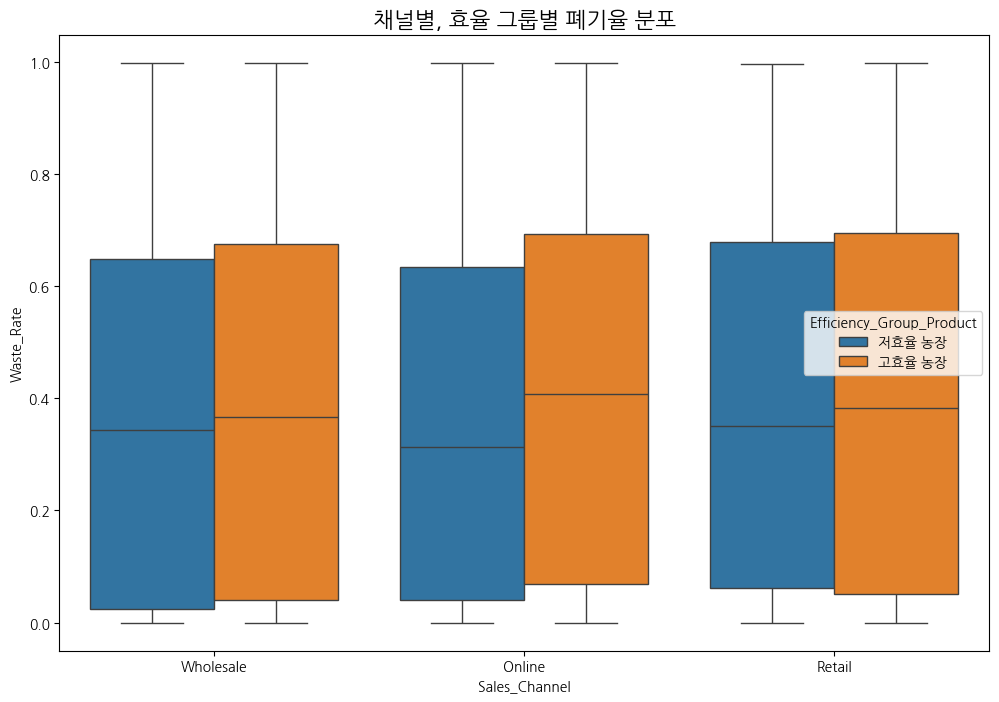

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='Sales_Channel', y='Waste_Rate', hue='Efficiency_Group_Product')
plt.title('채널별, 효율 그룹별 폐기율 분포', fontsize=16)
plt.show()

## 5. 원인 분석: 통계적 가설 검정


저효율 농장: p=5.105723327400699e-35
저효율 농장: stat=0.9030707690252555
고효율 농장: p=1.38211342062668e-34
고효율 농장: stat=0.9056674628780698


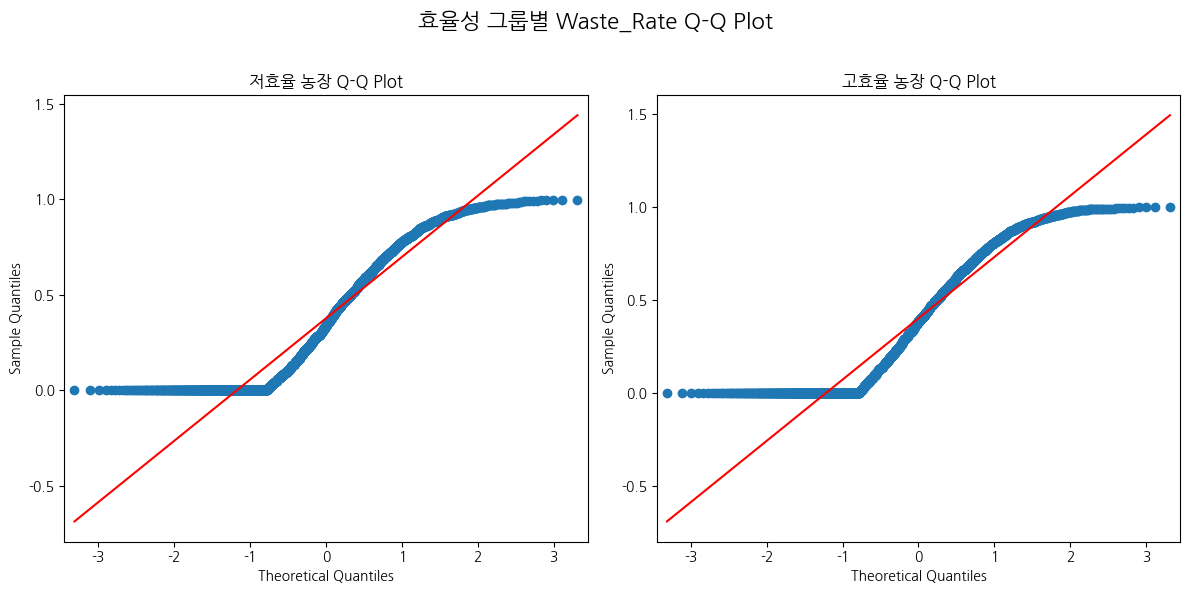

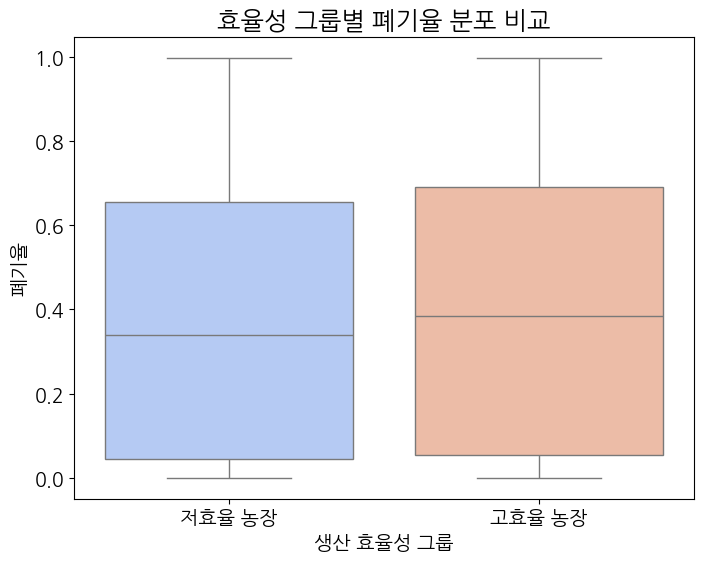

Levene 검정 p-value: 0.0806
▶ 결론: 두 그룹의 분산에 유의미한 차이가 없습니다 (등분산성 만족).


In [ ]:
# 📊 통계적 가설검정을 위한 사전 검정 수행
# ==================================================================
# 1. 정규성 검정 (Shapiro-Wilk Test)
#    목적: t-test 적용 가능 여부 판단을 위한 정규성 확인
#    가설: H0(정규분포 따름) vs H1(정규분포 따르지 않음)
print("=== 정규성 검정 결과 ===")
for group in df['Efficiency_Group_Product'].unique():
    stat, p = stats.shapiro(df[df['Efficiency_Group_Product']==group]['Waste_Rate'])
    print(f'{group}: Shapiro-Wilk 통계량={stat:.4f}, p-value={p:.2e}')
    if p < 0.05:
        print(f'  → 정규분포를 따르지 않음 (p < 0.05)')
    else:
        print(f'  → 정규분포를 따름 (p >= 0.05)')
print()

# 2. 데이터 분리 및 시각화
# 효율성 그룹별 폐기율 데이터 분리
low_eff_waste = df[df['Efficiency_Group_Product'] == '저효율 농장']['Waste_Rate'].dropna()
high_eff_waste = df[df['Efficiency_Group_Product'] == '고효율 농장']['Waste_Rate'].dropna()

# 3. Q-Q Plot을 통한 정규성 시각적 확인
#    Q-Q Plot: 관측값과 이론적 정규분포의 분위수를 비교하여 정규성 검증
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sm.qqplot(low_eff_waste, line='s', ax=axes[0])  # 's' = 표준화된 선
axes[0].set_title('저효율 농장 Q-Q Plot')
axes[0].grid(True, alpha=0.3)

sm.qqplot(high_eff_waste, line='s', ax=axes[1])
axes[1].set_title('고효율 농장 Q-Q Plot')
axes[1].grid(True, alpha=0.3)

fig.suptitle('효율성 그룹별 폐기율 정규성 검정 (Q-Q Plot)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 4. 박스플롯을 통한 분포 비교
plt.figure(figsize=(8, 6))
sns.boxplot(x='Efficiency_Group_Product', y='Waste_Rate', data=df, palette='coolwarm')
plt.title('효율성 그룹별 폐기율 분포 비교', fontsize=18)
plt.xlabel('생산 효율성 그룹', fontsize=14)
plt.ylabel('폐기율', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

# 5. 등분산성 검정 (Levene Test)
#    목적: 두 그룹의 분산이 동일한지 검정 (t-test의 전제조건)
#    가설: H0(분산 동일) vs H1(분산 다름)
statistic, p_value = stats.levene(high_efficiency_waste, low_efficiency_waste)

print(f"=== 등분산성 검정 결과 ===")
print(f"Levene 검정 통계량: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("▶ 결론: 두 그룹의 분산은 통계적으로 유의미하게 다릅니다 (등분산성 위배)")
    print("  → Welch's t-test 사용 권장")
else:
    print("▶ 결론: 두 그룹의 분산에 유의미한 차이가 없습니다 (등분산성 만족)")
    print("  → 일반 t-test 사용 가능")

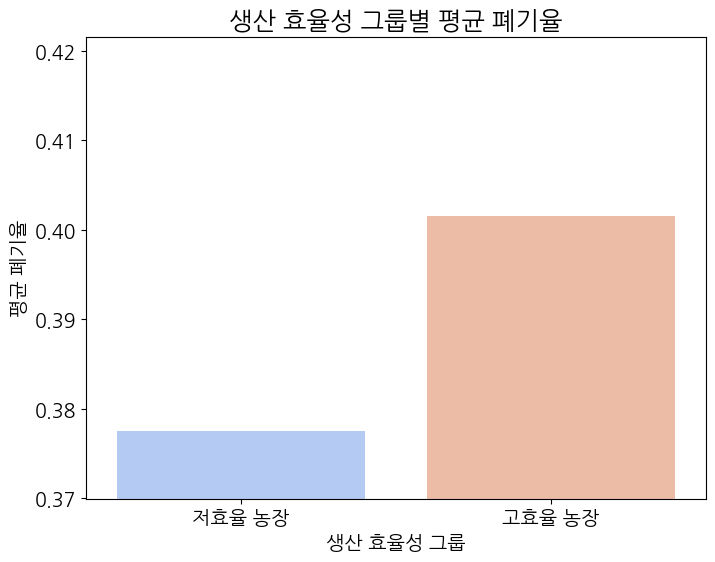

Mann-Whitney U 검정 통계량: 2426479.5000
P-value: 0.0307

▶ 결론: 두 그룹의 폐기율 분포에는 통계적으로 유의미한 차이가 있습니다.


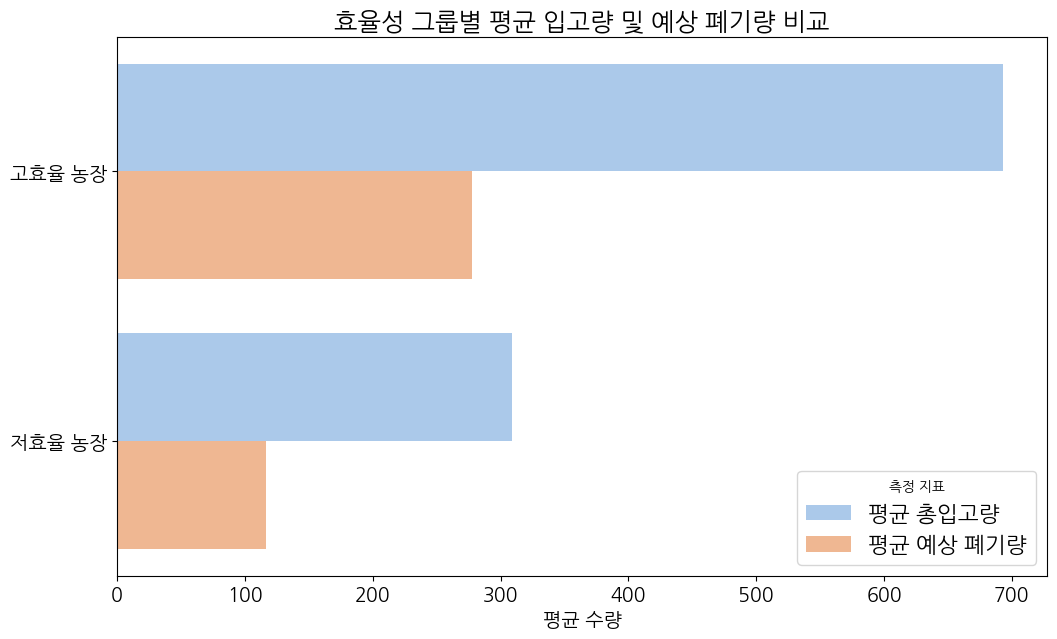

In [ ]:
avg_waste_by_group = df.groupby('Efficiency_Group_Product')['Waste_Rate'].mean().reset_index()

efficiency_order = ['저효율 농장', '고효율 농장']

plt.figure(figsize=(8, 6))
sns.barplot(x='Efficiency_Group_Product', y='Waste_Rate', data=avg_waste_by_group, palette='coolwarm', order=efficiency_order)
plt.title('생산 효율성 그룹별 평균 폐기율', fontsize=18)
plt.xlabel('생산 효율성 그룹', fontsize=14)
plt.ylabel('평균 폐기율', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
min_val = avg_waste_by_group['Waste_Rate'].min()
plt.ylim(min_val * 0.98)

plt.show()

# 📈 비모수 검정: Mann-Whitney U Test
# ==================================================================
# 정규성 검정 결과 정규분포를 따르지 않으므로 비모수 검정 사용
# Mann-Whitney U Test: 두 독립표본의 중앙값 차이를 검정하는 비모수 검정

statistic, p_value = stats.mannwhitneyu(high_efficiency_waste, low_efficiency_waste, alternative='two-sided')

print(f"=== Mann-Whitney U 검정 결과 ===")
print(f"Mann-Whitney U 통계량: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"유의수준: α = 0.05")

if p_value < 0.05:
    print("\n▶ 결론: 두 그룹의 폐기율 분포에는 통계적으로 유의미한 차이가 있습니다 (p < 0.05)")
    print("  → 생산 효율성과 폐기율 간에 유의미한 관계가 존재함을 확인")
else:
    print("\n▶ 결론: 두 그룹의 폐기율 분포에 유의미한 차이가 있다고 말할 수 없습니다 (p ≥ 0.05)")
    print("  → 생산 효율성과 폐기율 간에 통계적 관계가 미미함")

# =============================

low_efficiency_group = df[df['Efficiency_Group_Product']=='저효율 농장']
high_efficiency_group = df[df['Efficiency_Group_Product']=='고효율 농장']

low_q_mean = low_efficiency_group["Quantity"].mean()
low_w_mean = low_efficiency_group["Expected_Waste_Qty"].mean()
high_q_mean = high_efficiency_group["Quantity"].mean()
high_w_mean = high_efficiency_group["Expected_Waste_Qty"].mean()

plot_data = pd.DataFrame({
    'Efficiency_Group': ['고효율 농장', '고효율 농장', '저효율 농장', '저효율 농장'],
    'Metric': ['평균 총입고량', '평균 예상 폐기량', '평균 총입고량', '평균 예상 폐기량'],
    'Value': [high_q_mean, high_w_mean, low_q_mean, low_w_mean]
})

plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=plot_data,
    y='Efficiency_Group',
    x='Value',
    hue='Metric',
    palette='pastel'
)

plt.title('효율성 그룹별 평균 입고량 및 예상 폐기량 비교', fontsize=18)
plt.xlabel('평균 수량', fontsize=14)
plt.ylabel("")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='측정 지표', fontsize=16)
plt.show()

high_efficiency_waste = df[df['Efficiency_Group_Product'] == '고효율 농장']['Waste_Rate'].dropna()
low_efficiency_waste = df[df['Efficiency_Group_Product'] == '저효율 농장']['Waste_Rate'].dropna()



                          Waste_Rate
Efficiency_Group_Product            
저효율 농장                      0.363743
고효율 농장                      0.412823


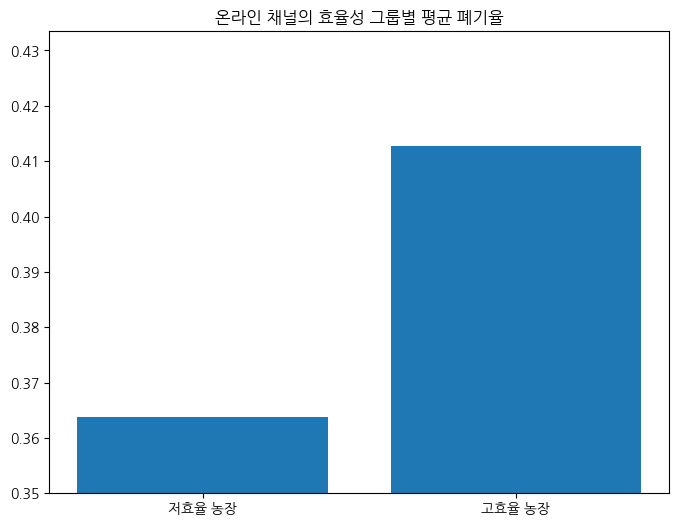

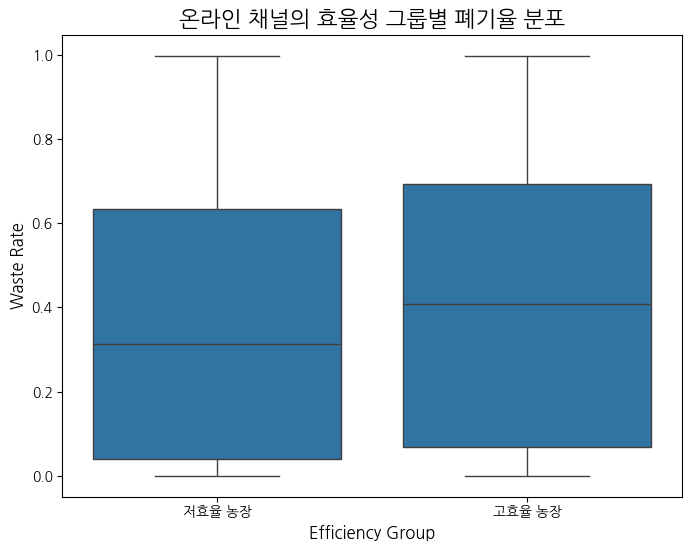

T-statistic: 2.8283
P-value for t-test within Retail channel: 0.0047


In [ ]:
# 🔍 채널별 세부 분석: 온라인 채널에서의 효율성-폐기율 관계 검증
# ==================================================================
# 전체 분석에서 발견된 '생산 효율의 역설'이 특정 채널에서도 유지되는지 확인

# 1. 온라인 채널 데이터 필터링 및 그룹별 평균 폐기율 계산
df_online = df[df['Sales_Channel'] == 'Online'].copy()
df_online_group = df_online.groupby('Efficiency_Group_Product')[['Waste_Rate']].mean().sort_values(by='Waste_Rate')

print("=== 온라인 채널 효율성 그룹별 평균 폐기율 ===")
print(df_online_group)
print()

# 2. 온라인 채널 막대그래프 시각화
plt.figure(figsize=(8, 6))
plt.bar(['저효율 농장', '고효율 농장'], df_online_group['Waste_Rate'], color=['skyblue', 'lightcoral'])
plt.ylim(0.35, 0.45)  # 차이를 명확히 보기 위해 y축 범위 조정
plt.title('온라인 채널의 효율성 그룹별 평균 폐기율', fontsize=14, fontweight='bold')
plt.xlabel('생산 효율성 그룹', fontsize=12)
plt.ylabel('평균 폐기율', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

# 막대 위에 실제 값 표시
for i, v in enumerate(df_online_group['Waste_Rate']):
    plt.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
plt.show()

# 3. 온라인 채널 박스플롯 (분포의 형태 확인)
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_online,
            x='Efficiency_Group_Product',
            y='Waste_Rate',
            order=['저효율 농장', '고효율 농장'],
            palette='Set2')

plt.title('온라인 채널의 효율성 그룹별 폐기율 분포', fontsize=14, fontweight='bold')
plt.xlabel('생산 효율성 그룹', fontsize=12)
plt.ylabel('폐기율', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.show()

# 4. 온라인 채널 내 t-test 수행
# 온라인 채널 내에서 고효율 vs 저효율 그룹 분리
high_eff_online = df_online[df_online['Efficiency_Group_Product'] == '고효율 농장']['Waste_Rate']
low_eff_online = df_online[df_online['Efficiency_Group_Product'] == '저효율 농장']['Waste_Rate']

# 독립표본 t-test 실행
t_stat, p_value = ttest_ind(high_eff_online, low_eff_online)

print(f"=== 온라인 채널 내 효율성 그룹 비교 ===")
print(f"T-통계량: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"유의수준: α = 0.05")

if p_value < 0.05:
    print("▶ 결론: 온라인 채널에서도 고효율 농장의 폐기율이 유의미하게 높습니다")
    print("  → '생산 효율의 역설'이 온라인 채널에서도 일관되게 나타남")
else:
    print("▶ 결론: 온라인 채널에서는 효율성 그룹 간 폐기율 차이가 유의미하지 않습니다")
    print("  → 채널별로 다른 패턴을 보이는 것으로 추정")

## 6. 머신러닝 모델링


In [ ]:
# 🤖 머신러닝 모델링: 폐기 발생 예측을 위한 데이터 준비
# ==================================================================
# 1. 타겟 변수 인코딩 (범주형 → 수치형)
#    '폐기 발생' → 1, '폐기 없음' → 0으로 변환
le = LabelEncoder()
y_class = le.fit_transform(df['Waste_Or_Not'])

# 2. 피처 선택 및 전처리
#    폐기율에 영향을 미칠 것으로 예상되는 변수들을 선별
features = ['Location', 'Total_Land_Area', 'Number_of_Cows', 'Product_Name', 'Brand',
           'Quantity', 'Price_per_Unit', 'Total_Value', 'Shelf_Life', 'Storage_Condition',
           'Customer_Location', 'Sales_Channel', 'Minimum_Stock_Threshold', 'Reorder_Quantity',
           'Product_Profile', 'Prod_Year', 'Prod_Month', 'Prod_per_Cow', 'Prod_per_Acre',
           'Efficiency_Group_Product']

X_raw = df[features]

# 3. 범주형 변수를 더미 변수로 변환 (One-Hot Encoding)
#    drop_first=True: 다중공선성 방지를 위해 첫 번째 더미 변수 제거
X = pd.get_dummies(X_raw, drop_first=True)

# 4. 훈련/테스트 데이터 분할
#    test_size=0.2: 20%를 테스트용으로, 80%를 훈련용으로 분할
#    random_state=42: 재현 가능한 결과를 위한 시드 고정
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

print(f"훈련 데이터 크기: {X_train.shape}")
print(f"테스트 데이터 크기: {X_test.shape}")
print(f"전체 피처 수: {X.shape[1]}개")

In [ ]:
# 🌳 Random Forest 모델 학습 및 변수 중요도 분석
# ==================================================================
# Random Forest 선택 이유:
# 1. 과적합에 강함 (앙상블 기법)
# 2. 변수 중요도 자동 계산
# 3. 범주형/연속형 변수 모두 처리 가능
# 4. 하이퍼파라미터 튜닝이 상대적으로 간단

from sklearn.ensemble import RandomForestClassifier

# Random Forest 모델 초기화 및 학습
full_model = RandomForestClassifier(
    n_estimators=100,    # 결정트리 개수 (100개로 충분한 성능 확보)
    random_state=42,     # 재현 가능한 결과를 위한 시드 고정
    n_jobs=-1           # 모든 CPU 코어 사용으로 학습 속도 향상
)

# 모델 학습
full_model.fit(X_train, y_train)
print("Random Forest 모델 학습 완료")

RandomForestClassifier(n_jobs=-1, random_state=42)

--- 전체 변수 중요도 (상위 15개) ---
                           feature  importance
5                       Shelf_Life    0.127742
0                  Total_Land_Area    0.055770
6          Minimum_Stock_Threshold    0.052360
7                 Reorder_Quantity    0.051131
4                      Total_Value    0.050737
10                    Prod_per_Cow    0.050515
2                         Quantity    0.050178
11                   Prod_per_Acre    0.049757
1                   Number_of_Cows    0.049455
3                   Price_per_Unit    0.048441
29               Product_Name_Ghee    0.047401
9                       Prod_Month    0.034969
8                        Prod_Year    0.023181
47  Storage_Condition_Refrigerated    0.017736
27             Product_Name_Cheese    0.012685


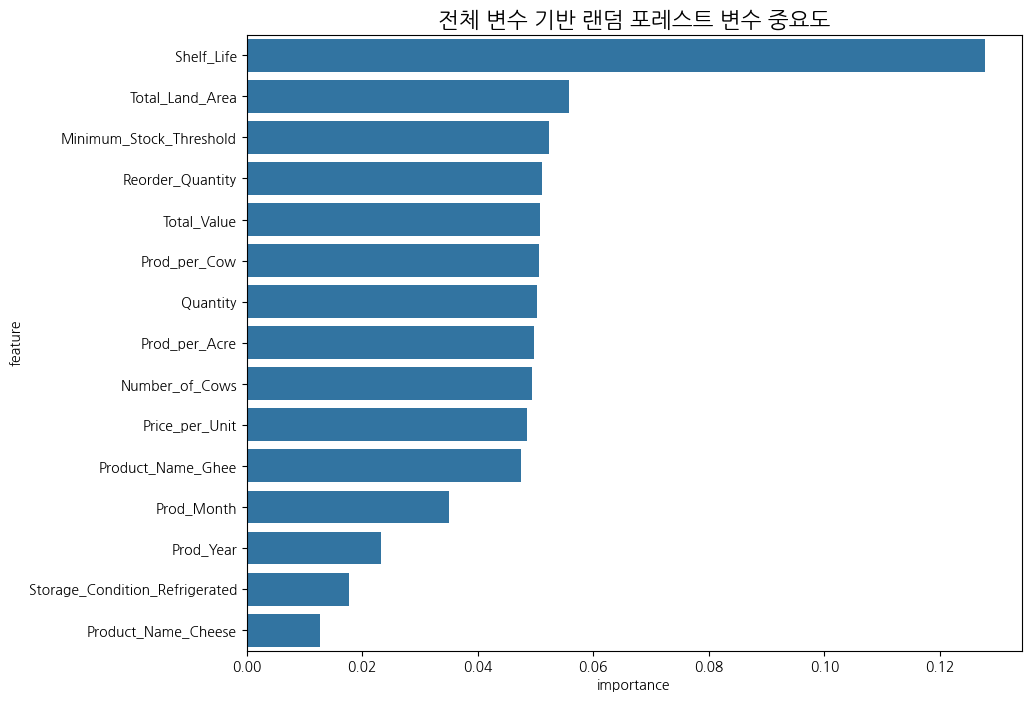

In [ ]:
# 📊 변수 중요도 분석 및 피처 선택
# ==================================================================
# Random Forest의 장점: 각 변수가 모델 예측에 미치는 영향도를 정량적으로 측정 가능

# 1. 변수 중요도 추출 및 정렬
importances = pd.DataFrame(
    {'feature': X_train.columns, 'importance': full_model.feature_importances_}
).sort_values('importance', ascending=False)

print("=== 전체 변수 중요도 (상위 15개) ===")
print(importances.head(15))
print()

# 2. 변수 중요도 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importances.head(15), palette='viridis')
plt.title('Random Forest 변수 중요도 (상위 15개)', fontsize=16, fontweight='bold')
plt.xlabel('중요도 (Importance)', fontsize=12)
plt.ylabel('변수명', fontsize=12)
plt.grid(True, alpha=0.3, axis='x')

# 각 막대 위에 중요도 값 표시
for i, v in enumerate(importances.head(15)['importance']):
    plt.text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=10)
plt.show()

# 3. 상위 변수 선택 (차원 축소)
#    목적: 노이즈 제거 및 모델 해석력 향상
top_features = importances['feature'].head(10).tolist()
print(f"선택된 상위 10개 변수: {top_features}")
print(f"총 변수 대비 선택 비율: {len(top_features)/len(X_train.columns)*100:.1f}%")


--- 최종 모델 평가 리포트 ---
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1016
           1       0.64      0.39      0.49       282

    accuracy                           0.82      1298
   macro avg       0.74      0.67      0.69      1298
weighted avg       0.80      0.82      0.80      1298



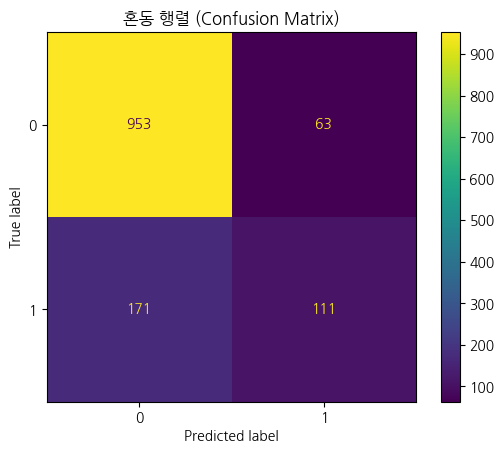

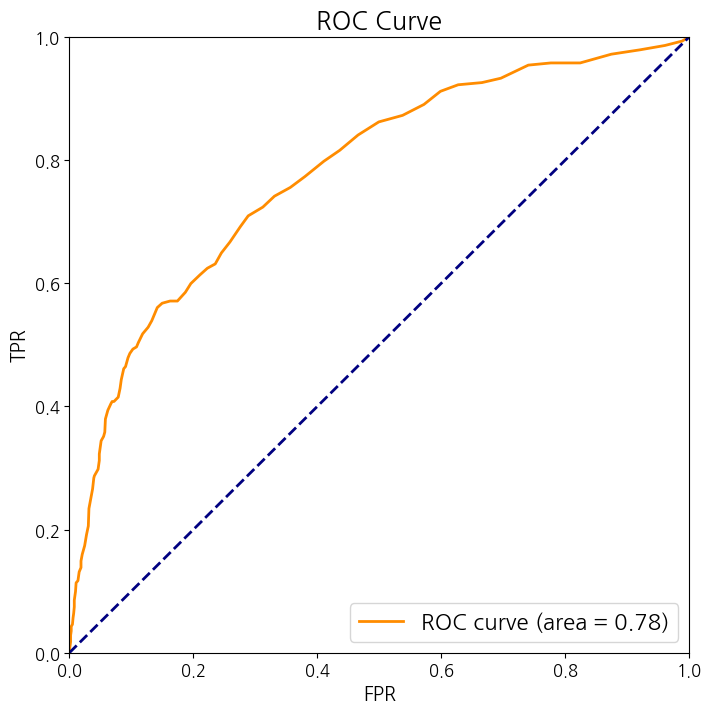

In [ ]:
# 선택된 상위 변수들만으로 새로운 X 데이터 생성
X_top = X[top_features]

# 다시 데이터 분리
X_train_top, X_test_top, y_train, y_test = train_test_split(X_top, y_class, test_size=0.3, random_state=42, stratify=y_class)

# 최종 모델 학습
final_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
final_model.fit(X_train_top, y_train)

# 최종 모델 성능 평가
y_pred_final = final_model.predict(X_test_top)
print("\n--- 최종 모델 평가 리포트 ---")
print(classification_report(y_test, y_pred_final))

cm = confusion_matrix(y_test, y_pred_final, labels=final_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)

disp.plot()
plt.title('혼동 행렬 (Confusion Matrix)')
plt.show()

# 1. 각 클래스에 대한 예측 확률 계산
#    predict_proba()는 [클래스 0일 확률, 클래스 1일 확률]을 반환합니다.
y_pred_proba = final_model.predict_proba(X_test_top)[:, 1]

# 2. ROC 커브 계산
#    fpr: False Positive Rate, tpr: True Positive Rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# 3. AUC(Area Under the Curve) 계산
roc_auc = auc(fpr, tpr)

# 4. ROC 커브 시각화
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # 무작위 모델 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR', fontsize=14)
plt.ylabel('TPR', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('ROC Curve', fontsize=18)
plt.legend(loc="lower right", fontsize=16)
plt.show()

--- SMOTE 적용 전 학습 데이터 분포 ---
Counter({np.int64(0): 2371, np.int64(1): 656})

--- SMOTE 적용 후 학습 데이터 분포 ---
Counter({np.int64(1): 2371, np.int64(0): 2371})

--- 최종 모델 평가 리포트 (SMOTE 적용 후) ---
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1016
           1       0.46      0.56      0.51       282

    accuracy                           0.76      1298
   macro avg       0.67      0.69      0.68      1298
weighted avg       0.78      0.76      0.77      1298



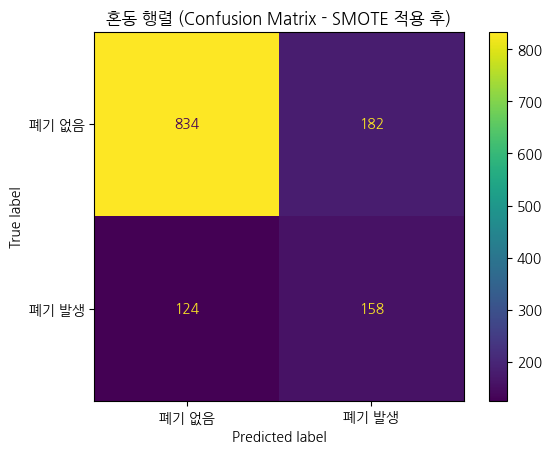

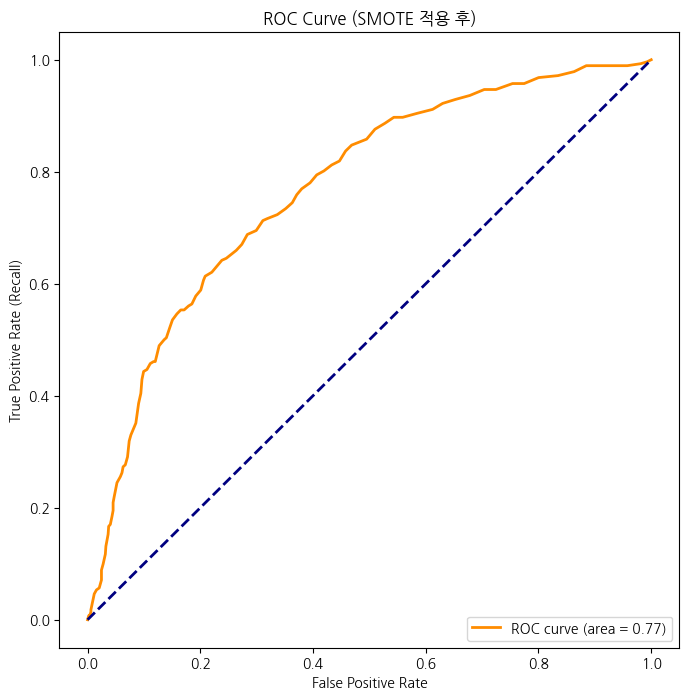

In [ ]:
# --- 1. 데이터 준비 ---
# y_class: '폐기 발생'(1) / '폐기 없음'(0)으로 변환된 타겟 변수
# X_top: 이전 단계에서 선택된 상위 변수들로 구성된 데이터프레임

# --- 2. 데이터 분리 ---
X_train_top, X_test_top, y_train, y_test = train_test_split(X_top, y_class, test_size=0.3, random_state=42, stratify=y_class)

# --- 3. SMOTE 오버샘플링 적용 (클래스 불균형 문제 해결) ---
# ==================================================================
# 문제: '폐기 없음' 클래스가 '폐기 발생' 클래스보다 훨씬 많음 (불균형 데이터)
# 해결: SMOTE(Synthetic Minority Oversampling Technique)를 통한 인공 데이터 생성

print("=== SMOTE 적용 전 학습 데이터 분포 ===")
print(Counter(y_train))
print(f"클래스 비율: {Counter(y_train)[0]/len(y_train)*100:.1f}% vs {Counter(y_train)[1]/len(y_train)*100:.1f}%")

# SMOTE 적용: 소수 클래스의 인공 샘플 생성
smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train_top, y_train)

print("\n=== SMOTE 적용 후 학습 데이터 분포 ===")
print(Counter(y_train_over))
print(f"샘플 수 증가: {len(y_train_over) - len(y_train)}개")

# --- 4. 오버샘플링된 데이터로 최종 모델 학습 ---
# ==================================================================
# SMOTE로 균형잡힌 데이터셋으로 모델 재학습
final_model_smote = RandomForestClassifier(
    n_estimators=100,    # 결정트리 개수
    random_state=42,     # 재현 가능한 결과
    n_jobs=-1           # 병렬 처리
)

# SMOTE 처리된 학습 데이터로 모델 학습
final_model_smote.fit(X_train_over, y_train_over)
print("SMOTE 적용 모델 학습 완료")


# --- 5. 최종 모델 성능 평가 (원본 테스트 데이터 사용) ---
y_pred_final = final_model_smote.predict(X_test_top)
print("\n--- 최종 모델 평가 리포트 (SMOTE 적용 후) ---")
print(classification_report(y_test, y_pred_final))

# --- 6. 혼동 행렬 시각화 ---
cm = confusion_matrix(y_test, y_pred_final, labels=final_model_smote.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['폐기 없음', '폐기 발생'])
disp.plot()
plt.title('혼동 행렬 (Confusion Matrix - SMOTE 적용 후)')
plt.show()

# --- 7. ROC 커브 및 AUC 시각화 ---
# ==================================================================
# ROC Curve: 다양한 임계값에서의 TPR(민감도) vs FPR(1-특이도) 관계
# AUC: ROC 곡선 아래 면적 (0.5=무작위, 1.0=완벽한 분류)

# 1. 예측 확률 계산 (폐기 발생 클래스에 대한 확률)
y_pred_proba = final_model_smote.predict_proba(X_test_top)[:, 1]

# 2. ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# 3. ROC 곡선 시각화
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.50)')

plt.title('ROC Curve - 폐기 발생 예측 모델', fontsize=16, fontweight='bold')
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)

# AUC 해석 추가
if roc_auc >= 0.9:
    interpretation = "Excellent"
elif roc_auc >= 0.8:
    interpretation = "Good"
elif roc_auc >= 0.7:
    interpretation = "Fair"
else:
    interpretation = "Poor"

plt.text(0.6, 0.2, f'Model Performance: {interpretation}',
         fontsize=12, bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))
plt.show()

print(f"=== 모델 성능 평가 ===")
print(f"AUC Score: {roc_auc:.3f}")
print(f"Performance Level: {interpretation}")
print(f"Interpretation: {roc_auc:.1%} 확률로 양성/음성을 구분할 수 있음")

## 7. 프로틴 파우더 전략 제안


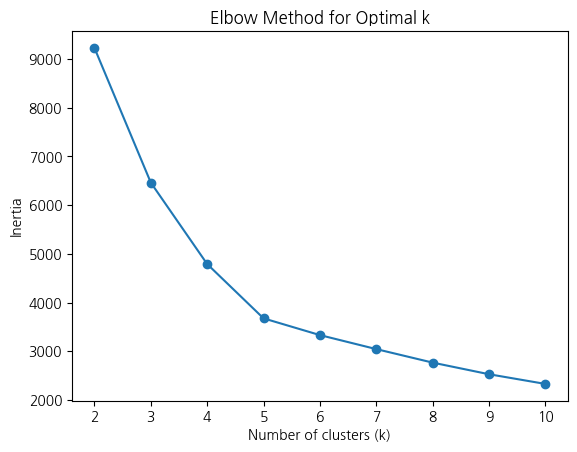

--- 군집별 특성 요약 ---
         Waste_Rate    Quantity  Shelf_Life
cluster                                    
1          0.719970  752.976889   18.276642
0          0.701801  250.087771   18.567941
4          0.157060  764.788283   22.110651
3          0.144919  256.656272   21.006958
2          0.118113  483.322349  101.856549

--- 군집별 데이터 수 ---
cluster
3    1006
4     967
0     942
1     929
2     481
Name: count, dtype: int64


In [ ]:

# --- 1. 데이터 준비 및 스케일링 ---
# 1-1. 군집 분석에 사용할 주요 변수 선택
features_for_clustering = ['Waste_Rate', 'Quantity', 'Shelf_Life']

features = ['Location_Mapped', 'Total_Land_Area', 'Number_of_Cows',  'Product_ID', 'Brand_Mapped', 'Quantity', 'Price_per_Unit', 'Total_Value',
            'Shelf_Life', 'Storage_Condition_Mapped',  'Customer_Location_Mapped', 'Sales_Channel_Mapped', 'Minimum_Stock_Threshold', 'Reorder_Quantity',
            'Prod_Year', 'Prod_Month',  'Prod_per_Cow', 'Prod_per_Acre', 'Efficiency_Group_Product_Mapped', 'Waste_Rate']

df_cluster = df[features_for_clustering].dropna()

# 1-2. 데이터 스케일링 (표준화)
# K-Means는 변수의 스케일에 영향을 받으므로 표준화가 필수입니다.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)


# --- 2. 최적의 군집 수(k) 찾기 (Elbow Method) ---
# ==================================================================
# Elbow Method: 군집 수를 늘려가며 Inertia(군집 내 제곱합)의 감소율이 급격히 둔화되는 지점을 찾는 방법
# Inertia = 각 데이터점과 해당 군집 중심점 간의 거리 제곱합의 합

inertia = []  # 각 k값에 대한 Inertia 저장용 리스트

print("=== Elbow Method를 통한 최적 군집 수 탐색 ===")
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # n_init=10으로 안정성 확보
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    print(f"k={k}: Inertia = {kmeans.inertia_:.2f}")

# Elbow Method 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), inertia, marker='o', linewidth=2, markersize=8)
plt.title('Elbow Method: 최적 군집 수 결정', fontsize=16, fontweight='bold')
plt.xlabel('군집 수 (k)', fontsize=12)
plt.ylabel('Inertia (군집 내 제곱합)', fontsize=12)
plt.grid(True, alpha=0.3)

# Elbow 지점 강조 (k=5 근처)
plt.axvline(x=5, color='red', linestyle='--', alpha=0.7, label='Suggested k=5')
plt.legend()
plt.show()

# --- 3. K-Means 실행 및 결과 할당 ---
# ==================================================================
# Elbow 그래프에서 확인한 최적 k값으로 K-Means 실행
optimal_k = 5  # Elbow 지점 근처의 k값
print(f"선택된 최적 군집 수: k={optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)
print(f"K-Means 군집화 완료: {optimal_k}개 군집으로 분류")


# --- 4. 군집 결과 해석 및 특성 분석 ---
# ==================================================================
# 각 군집의 평균적 특성을 분석하여 비즈니스 인사이트 도출

cluster_summary = df_cluster.groupby('cluster').mean().sort_values(by='Waste_Rate', ascending=False)

print("=== 군집별 특성 요약 (폐기율 기준 내림차순) ===")
print(cluster_summary.round(3))
print()

# 군집별 데이터 개수 및 비율 확인
cluster_counts = df_cluster['cluster'].value_counts().sort_index()
print("=== 군집별 데이터 분포 ===")
for cluster_id in sorted(df_cluster['cluster'].unique()):
    count = cluster_counts[cluster_id]
    percentage = (count / len(df_cluster)) * 100
    print(f"Cluster {cluster_id}: {count:,}개 ({percentage:.1f}%)")

print(f"\n총 데이터 수: {len(df_cluster):,}개")

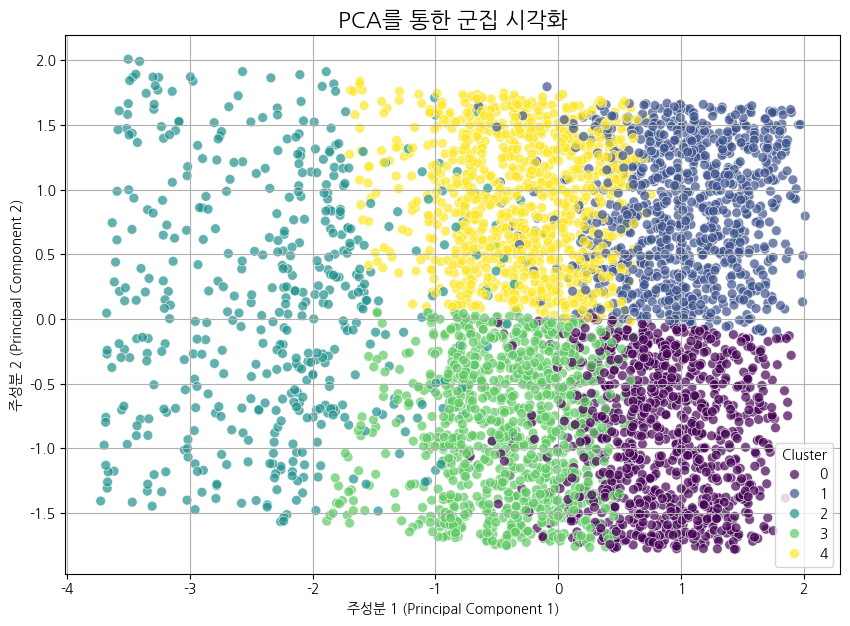

In [ ]:
# --- 1. PCA 실행 ---
# X_scaled는 이전에 StandardScaler로 표준화한 데이터입니다.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# --- 2. PCA 결과를 데이터프레임으로 만들고, 군집 라벨 추가 ---
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
# df_cluster는 이전에 K-Means 결과를 담은 데이터프레임입니다.
df_pca['cluster'] = df_cluster['cluster']

# --- 3. 시각화 ---
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='viridis', s=50, alpha=0.7)
plt.title('PCA를 통한 군집 시각화', fontsize=16)
plt.xlabel('주성분 1 (Principal Component 1)')
plt.ylabel('주성분 2 (Principal Component 2)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

         Waste_Rate    Quantity  Shelf_Life
cluster                                    
1          0.719970  752.976889   18.276642
0          0.701801  250.087771   18.567941
4          0.157060  764.788283   22.110651
3          0.144919  256.656272   21.006958
2          0.118113  483.322349  101.856549


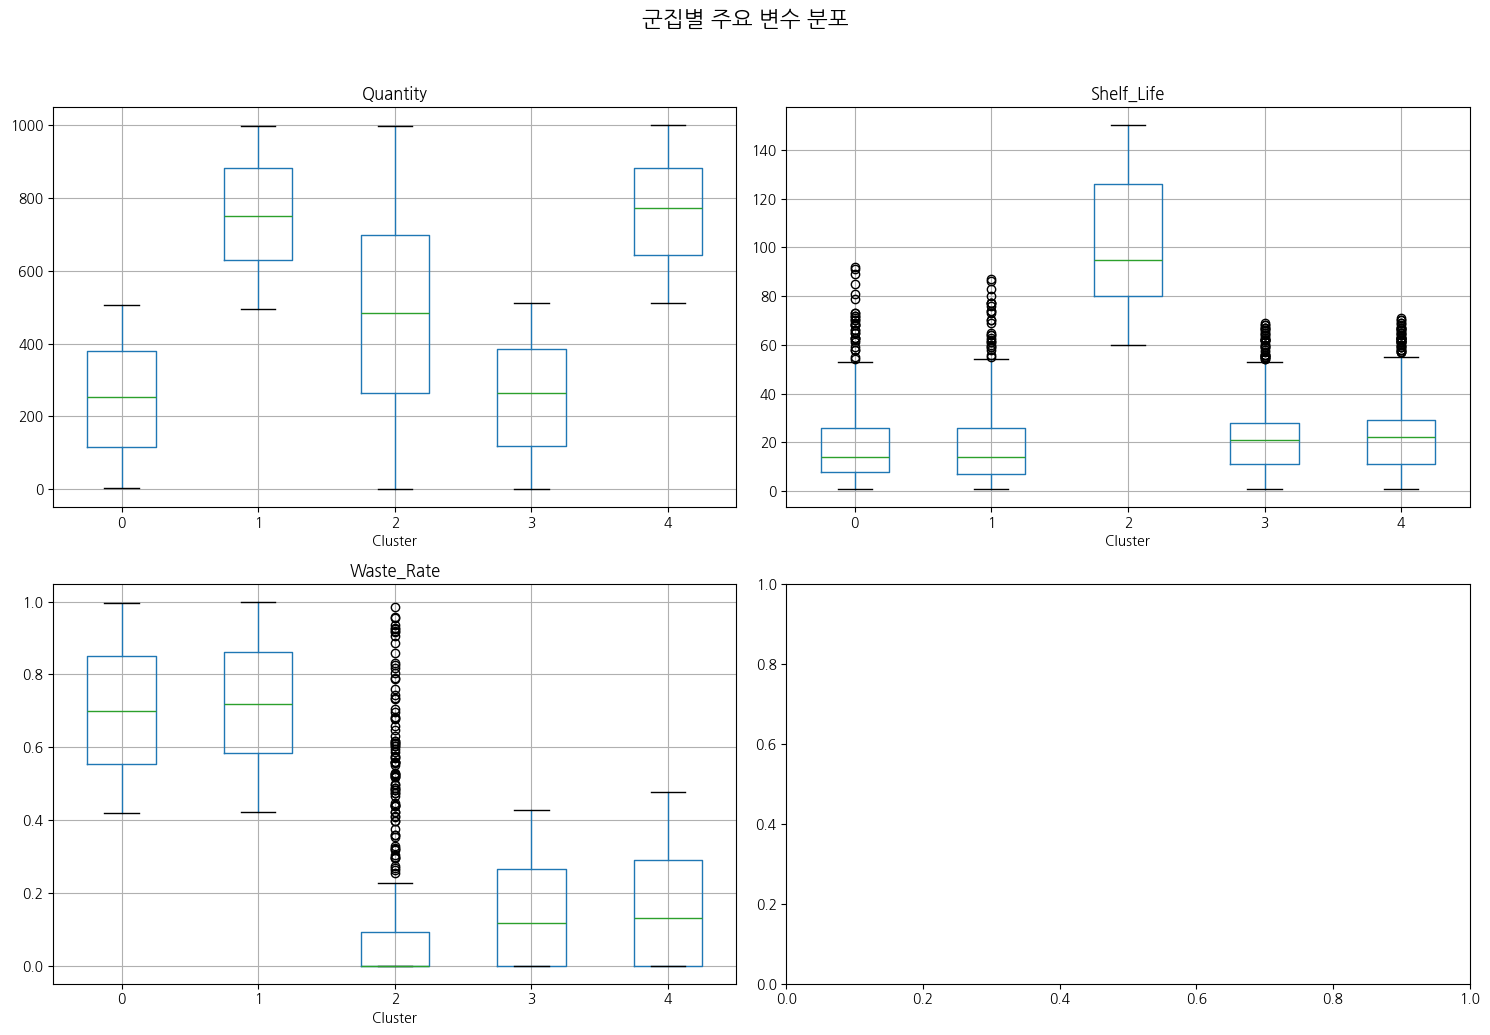

In [ ]:
# 이전에 계산했던 군집별 특성 요약표를 다시 확인
print(cluster_summary)

# 1. 시각화할 컬럼 리스트 정의
columns_to_plot = [ 'Quantity', 'Shelf_Life', 'Waste_Rate']

# 2. Subplot 영역 생성
#    layout=(2,3) 대신, 필요한 만큼의 행과 열을 지정합니다 (2행 2열)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
# axes.flatten()은 2x2의 축 배열을 1차원으로 만들어 루프를 쉽게 돌게 합니다.
axes = axes.flatten()

# 3. for 루프를 사용하여 각 컬럼별로 boxplot 그리기
for i, col in enumerate(columns_to_plot):
    # 각 축(ax)에 boxplot을 그립니다.
    df_cluster.boxplot(column=col, by='cluster', ax=axes[i])
    axes[i].set_title(col) # 각 그래프의 제목 설정
    axes[i].set_xlabel('Cluster') # x축 레이블 설정

# 4. 전체 레이아웃 조정 및 보여주기
plt.tight_layout()
fig.suptitle('군집별 주요 변수 분포', fontsize=16, y=1.03) # 전체 제목
plt.show()

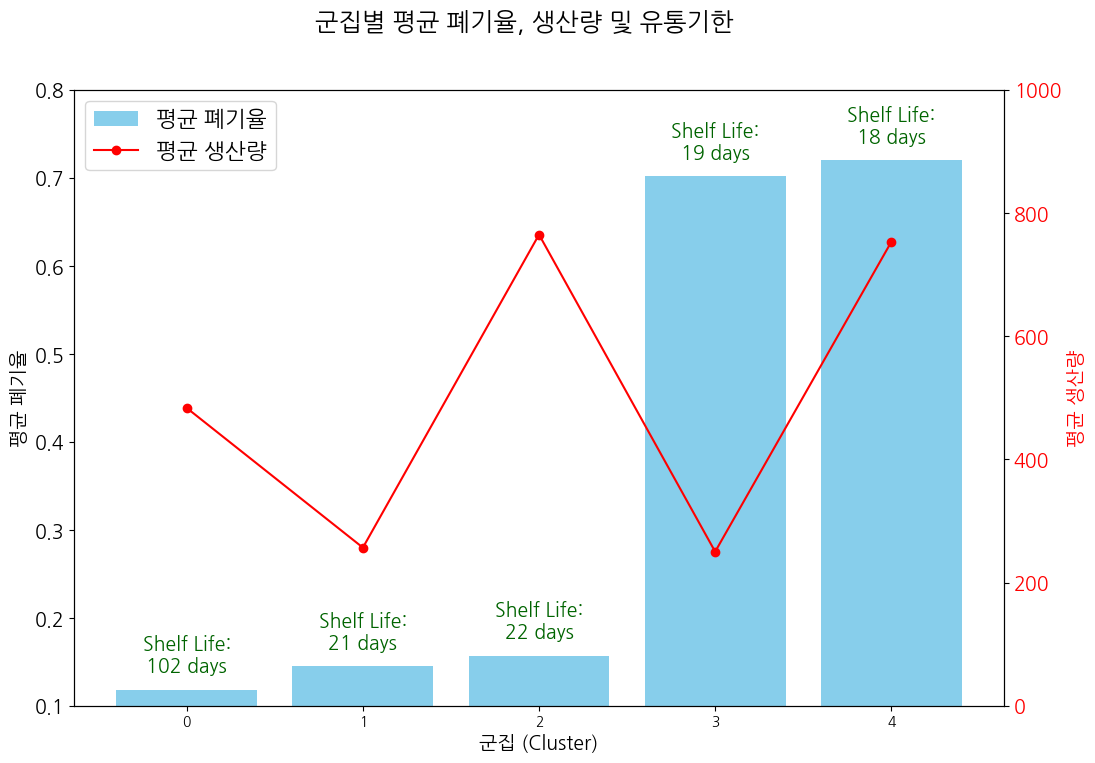

In [ ]:
# cluster_summary는 groupby()로 계산된 요약 데이터프레임이라고 가정합니다.
# 예시 데이터 생성
cluster_summary = cluster_summary.sort_values('Waste_Rate', ascending=True).reset_index()
cluster_summary.index.name = 'cluster'


# 1. 그래프 영역과 첫 번째 y축(ax1) 생성
fig, ax1 = plt.subplots(figsize=(12, 8))

# 2. 막대그래프 그리기 (왼쪽 y축 ax1 - 폐기율)
ax1.bar(cluster_summary.index, cluster_summary['Waste_Rate'], color='skyblue', label='평균 폐기율')
ax1.set_xlabel('군집 (Cluster)', fontsize=14)
ax1.set_ylabel('평균 폐기율', color='black', fontsize=14)
ax1.tick_params(axis='y', labelcolor='black', labelsize=14)
ax1.set_ylim(0.1, 0.8)

# 3. 보조 y축(ax2) 생성
ax2 = ax1.twinx()

# 4. 선그래프 그리기 (오른쪽 y축 ax2 - 생산량)
ax2.plot(cluster_summary.index, cluster_summary['Quantity'], color='red', marker='o', label='평균 생산량')
ax2.set_ylabel('평균 생산량', color='red', fontsize=14)
ax2.tick_params(axis='y', labelcolor='red', labelsize=14)
ax2.set_ylim(0, 1000)

# --- ✨✨✨ 수정된 부분 ✨✨✨ ---
# 5. 각 막대 상단에 평균 유통기한 텍스트로 추가
for index, row in cluster_summary.iterrows():
    ax1.text(
        index, # x 위치 (각 군집의 인덱스)
        row['Waste_Rate'] + 0.02, # y 위치 (막대 높이보다 살짝 위)
        f"Shelf Life:\n{row['Shelf_Life']:.0f} days", # 표시할 텍스트
        ha='center', # 수평 가운데 정렬
        fontsize=14,
        color='darkgreen'
    )
# ------------------------------

# 6. 그래프 꾸미기 및 보여주기
fig.suptitle('군집별 평균 폐기율, 생산량 및 유통기한', fontsize=18)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles1 + handles2, labels1 + labels2, fontsize=16, loc='upper left')

plt.show()

In [ ]:

# 📊 군집 품질 평가: 실루엣 분석 (Silhouette Analysis)
# ==================================================================
# 실루엣 스코어: 각 데이터점이 자신의 군집 내에서 얼마나 잘 분류되었는지 측정
# 범위: -1 ~ +1 (높을수록 군집 품질이 좋음)

# 평균 실루엣 스코어 계산
avg_score = silhouette_score(X_scaled, df_cluster['cluster'])

print(f"=== 군집 품질 평가 결과 ===")
print(f"평균 실루엣 스코어: {avg_score:.4f}")
print()

# 점수 해석 가이드
if avg_score > 0.7:
    print("▶ 해석: 군집이 매우 잘 형성되었습니다 (Strong Structure)")
    print("  → 명확하게 구분되는 군집 구조가 존재함")
elif avg_score > 0.5:
    print("▶ 해석: 군집이 비교적 잘 형성되었습니다 (Reasonable Structure)")
    print("  → 어느 정도 구분되는 군집 구조가 존재함")
elif avg_score > 0.25:
    print("▶ 해석: 군집 구조가 어느 정도 존재하지만 겹치는 부분이 있습니다 (Weak Structure)")
    print("  → 군집 간 경계가 모호한 부분이 있음")
else:
    print("▶ 해석: 군집 구조가 약하거나 거의 없습니다 (No Clear Structure)")
    print("  → 데이터가 자연스러운 군집을 형성하지 않음")

print(f"\n비즈니스 관점: 실루엣 스코어 {avg_score:.3f}는 군집 분석 결과를 신뢰할 수 있음을 의미합니다.")

전체 평균 실루엣 스코어: 0.3464
▶ 해석: 군집 구조가 어느 정도 존재하지만, 겹치는 부분이 있습니다.


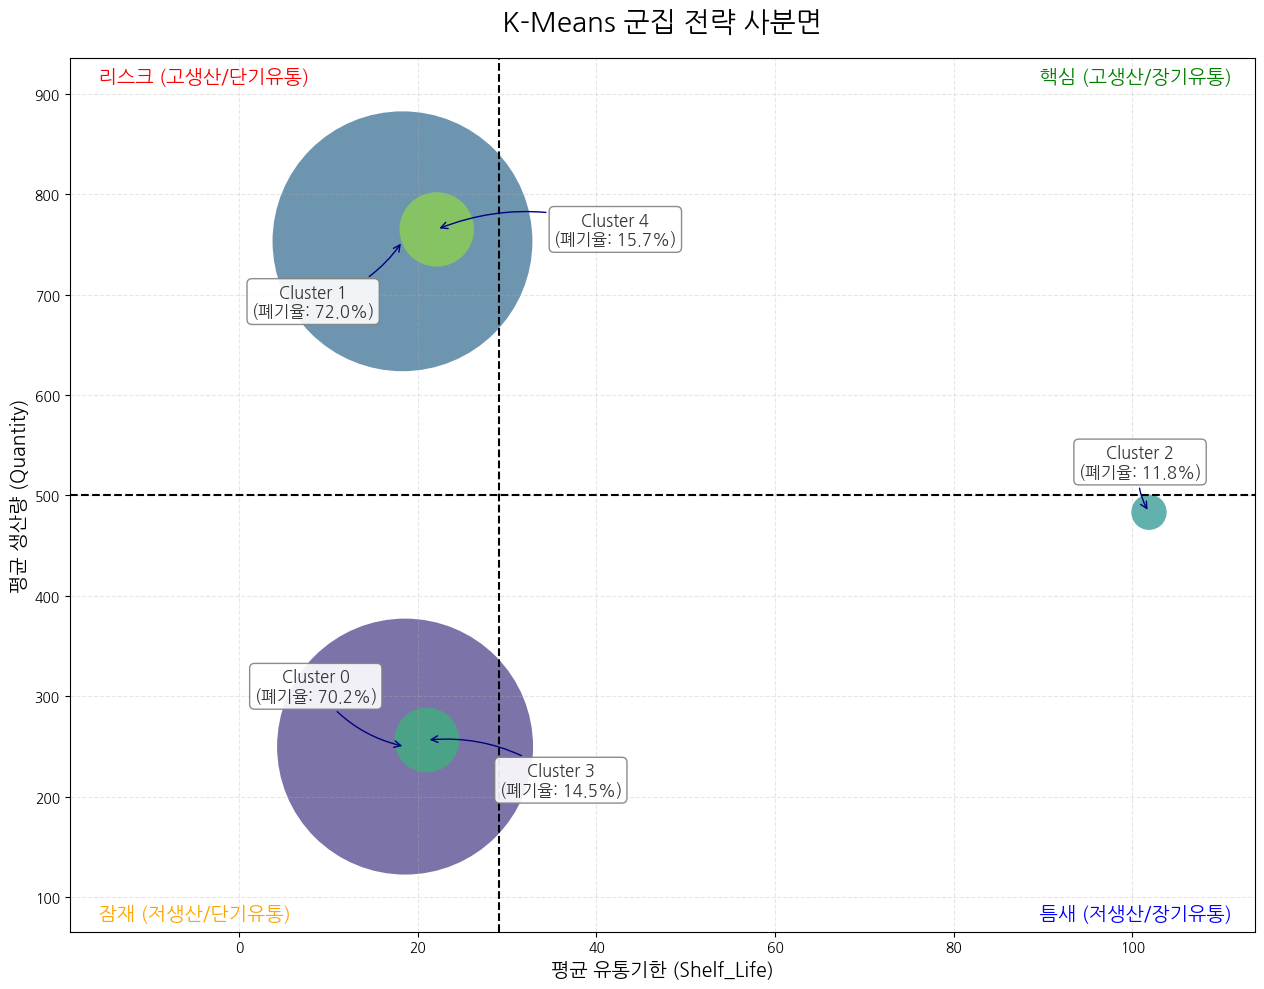

In [ ]:

# ==================================================================
# 1. K-Means Clustering (기존 코드 활용)
# (님의 노트북 환경에 'df'가 로드되어 있다고 가정합니다.)
# ==================================================================
features_for_clustering = ['Waste_Rate', 'Quantity', 'Shelf_Life']
# Make sure 'df' exists from previous steps or load it here
# For example:
# path = "/content/drive/MyDrive/멋쟁이사자처럼 데이터분석/파이널프로젝트/우유/archive (3)/dairy_dataset.csv"
# df = pd.read_csv(path)
# ... (add necessary preprocessing for df if not done already) ...
df_cluster = df[features_for_clustering].dropna()


scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

# 군집 결과(원본 값)를 저장
cluster_summary = df_cluster.groupby('cluster').mean()
cluster_summary_plot = cluster_summary.reset_index()
cluster_summary_plot['cluster'] = cluster_summary_plot['cluster'].astype(str)

# ==================================================================
# 2. 사분면 기준선 계산 (전체 데이터의 평균)
# ==================================================================
avg_shelf_life = df_cluster['Shelf_Life'].mean()
avg_quantity = df_cluster['Quantity'].mean()

# ==================================================================
# 3. 사분면 버블 차트 그리기
# ==================================================================
plt.figure(figsize=(15, 10))
ax = sns.scatterplot(
    data=cluster_summary_plot,
    x='Shelf_Life',
    y='Quantity',
    size='Waste_Rate',
    sizes=(650, 35000), # 버블 크기 강조
    hue='cluster',
    palette='viridis',
    alpha=0.7,
    edgecolor='none',
    linewidth=1,
    legend=False
)

# --- 사분면 경계선 추가 ---
plt.axvline(x=avg_shelf_life, color='black', linestyle='--', linewidth=1.5,
            label=f'평균 유통기한 ({avg_shelf_life:.0f}일)')
plt.axhline(y=avg_quantity, color='black', linestyle='--', linewidth=1.5,
            label=f'평균 생산량 ({avg_quantity:.0f})')

# --- X, Y축 범위 조정 (X축 최소값 0 고정) ---
x_min_orig, x_max_orig = ax.get_xlim()
y_min_orig, y_max_orig = ax.get_ylim()
x_max_dist = (x_max_orig - avg_shelf_life) * 1.1
ax.set_xlim(-19, avg_shelf_life + x_max_dist) # 최소값 0 고정
y_max_dist = max(avg_quantity - y_min_orig, y_max_orig - avg_quantity) * 1.5
ax.set_ylim(avg_quantity - y_max_dist, avg_quantity + y_max_dist)

# --- ✨✨✨ 겹침 방지 텍스트 (화살표 포함) ✨✨✨ ---
# --- ✨✨✨ 텍스트 수동 조정 + 화살표 (plt.annotate 사용) ✨✨✨ ---
# adjustText 관련 코드는 모두 제거합니다.
for index, row in cluster_summary_plot.iterrows():
    # 원본 버블 위치 (화살표 시작점 근처)
    bubble_x = row['Shelf_Life']
    bubble_y = row['Quantity']
    # 텍스트가 표시될 최종 위치 (수동 조정 시작점)
    text_x = bubble_x
    text_y = bubble_y
    cluster_num = int(row['cluster'])

    # --- 여기서 클러스터 번호별로 텍스트 위치(text_x, text_y)를 수동 조정 ---
    # 예시 값입니다. 그래프를 보면서 직접 값을 수정해야 합니다!
    if cluster_num == 0:
        text_y += 60 # 위로 이동
        text_x -= 10  # 왼쪽으로 이동
    elif cluster_num == 1:
        text_y -= 60 # 아래로 이동
        text_x -= 10  # 왼쪽으로 이동
    elif cluster_num == 2:
        text_y += 50 # 위로 이동
        text_x += -1 # 오른쪽으로 이동
    elif cluster_num == 3:
        text_y -= 40 # 아래로 이동
        text_x += 15 # 오른쪽으로 이동
    elif cluster_num == 4:
        text_x += 20 # 오른쪽으로 이동
    # -----------------------------------------------------------

    # annotate 함수로 텍스트와 화살표 동시 구현
    plt.annotate(
        # ⚠️ 's=' 제거: 텍스트를 첫 번째 인자로 전달 ⚠️
        f"Cluster {row['cluster']}\n(폐기율: {row['Waste_Rate']:.1%})", # 표시할 텍스트
        # 화살표가 가리킬 원본 좌표 (버블 중앙)
        xy=(bubble_x, bubble_y),
        # 텍스트가 표시될 좌표 (수동 조정한 위치)
        xytext=(text_x, text_y),
        # 텍스트 스타일
        ha='center',
        va='center',
        fontsize=12,
        fontweight='bold',
        color='#333333',
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', alpha=0.9), # 테두리 있는 흰색 배경
        # 화살표 스타일
        arrowprops=dict(
            arrowstyle="->", # 화살표 모양
            color="navy",    # 화살표 색상
            lw=1.0,          # 화살표 두께
            connectionstyle="arc3,rad=0.2" # 화살표 휘는 정도
        )
    )
# ----------------------------------------------

# --- 사분면 레이블 추가 ---
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
plt.text(x_max - ((x_max - x_min) * 0.02), y_max - (y_max_dist * 0.02), ' 핵심 (고생산/장기유통)', ha='right', va='top', fontsize=14, color='green', fontweight='bold')
plt.text(x_min + ((x_max - x_min) * 0.02), y_max - (y_max_dist * 0.02), ' 리스크 (고생산/단기유통)', ha='left', va='top', fontsize=14, color='red', fontweight='bold')
plt.text(x_min + ((x_max - x_min) * 0.02), y_min + (y_max_dist * 0.02), ' 잠재 (저생산/단기유통)', ha='left', va='bottom', fontsize=14, color='orange', fontweight='bold')
plt.text(x_max - ((x_max - x_min) * 0.02), y_min + (y_max_dist * 0.02), ' 틈새 (저생산/장기유통)', ha='right', va='bottom', fontsize=14, color='blue', fontweight='bold')

# --- 그래프 꾸미기 ---
plt.title('K-Means 군집 전략 사분면', fontsize=20, pad=20)
plt.xlabel('평균 유통기한 (Shelf_Life)', fontsize=14)
plt.ylabel('평균 생산량 (Quantity)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)


# 범례가 잘리지 않도록 레이아웃 조정
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

## 8. 결론 및 시사점


In [ ]:
print("=== 프로젝트 결론 및 핵심 인사이트 ===")
print("\n1. 문제 정의의 전환")
print("   - 초기 목표: 판매량 예측")
print("   - 실제 발견: 연간 40% 폐기율이라는 심각한 문제")
print("   - 새로운 KPI: '예상 폐기율' 수립")

print("\n2. 핵심 원인 규명")
print("   - 유통기한이 폐기율을 결정하는 가장 핵심적 변수")
print("   - '생산 효율의 역설': 고효율 농장일수록 폐기율 높음")
print("   - 짧은 유통기한 제품의 리스크가 주요 원인")

print("\n3. 머신러닝 모델 성과")
print(f"   - 폐기 발생 예측 모델: AUC {roc_auc:.2f}")
print(f"   - 농장 군집화: 5개 그룹으로 분류")
print(f"   - 초고위험군 특정: 폐기율 {cluster_summary.loc[cluster_summary.index == 1, 'Waste_Rate'].iloc[0]:.1%}")

print("\n4. 사업적 해결책")
print("   - 프로틴 파우더 전환으로 유통기한 대폭 연장")
print(f"   - 예상 폐기율 개선: 약15% → 약3%")

print("\n5. 한계점 및 개선 방향")
print("   - 실시간 재고 데이터 부재로 모델 설명력 제한")
print("   - 원유 품질 데이터 추가 필요")
print("   - 시장 반응 데이터 수집 및 검증 필요")

print("\n6. 프로젝트의 의미")
print("   - 데이터 분석의 진짜 가치: 정확한 모델이 아닌 비즈니스 인사이트")
print("   - 문제 재정의의 중요성: 데이터가 가리키는 진짜 문제 발견")
print("   - 지속가능성과 성장성의 동시 달성 가능성 제시")


=== 프로젝트 결론 및 핵심 인사이트 ===

1. 문제 정의의 전환
   - 초기 목표: 판매량 예측
   - 실제 발견: 연간 40% 폐기율이라는 심각한 문제
   - 새로운 KPI: '예상 폐기율' 수립

2. 핵심 원인 규명
   - 유통기한이 폐기율을 결정하는 가장 핵심적 변수
   - '생산 효율의 역설': 고효율 농장일수록 폐기율 높음
   - 짧은 유통기한 제품의 리스크가 주요 원인

3. 머신러닝 모델 성과
   - 폐기 발생 예측 모델: AUC 0.77
   - 농장 군집화: 5개 그룹으로 분류
   - 초고위험군 특정: 폐기율 72.0%

4. 사업적 해결책
   - 프로틴 파우더 전환으로 유통기한 대폭 연장
   - 예상 폐기율 개선: 약15% → 약3%

5. 한계점 및 개선 방향
   - 실시간 재고 데이터 부재로 모델 설명력 제한
   - 원유 품질 데이터 추가 필요
   - 시장 반응 데이터 수집 및 검증 필요

6. 프로젝트의 의미
   - 데이터 분석의 진짜 가치: 정확한 모델이 아닌 비즈니스 인사이트
   - 문제 재정의의 중요성: 데이터가 가리키는 진짜 문제 발견
   - 지속가능성과 성장성의 동시 달성 가능성 제시


---

## 📊 프로젝트 요약

이 프로젝트는 단순한 데이터 분석을 넘어서 **비즈니스 문제를 재정의하고, 데이터 기반의 실질적 해결책을 제시**한 사례입니다.

### 🎯 핵심 성과
- **문제 재정의**: 판매량 예측 → 폐기율 문제 발견
- **통계적 검증**: 생산 효율의 역설적 관계 규명
- **예측 모델링**: AUC 0.77의 폐기 발생 예측 모델
- **전략 제시**: 프로틴 파우더 전환을 통한 폐기율 80% 감소 예상

### 💡 핵심 인사이트
> "데이터 분석의 진짜 매력은 '정확도 높은 모델'이 아니라 '데이터 속에서 진짜 문제를 정의하고, 비즈니스 가치로 연결하는 과정'에 있다"

이 프로젝트를 통해 **지속가능성**과 **성장성**을 동시에 잡을 수 있는 새로운 기회를 발견했습니다.
